In [2]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pathlib

In [4]:
import pandas as pd
import numpy as np

In [5]:
DATA_DIR = pathlib.Path("../data")

# Loading the data

The data is from here: https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

In [6]:
!ls "../data"

AEP_hourly.csv.zip
FordA.zip
LD2011_2014.txt
maintenance.txt


In [7]:
# eldata = pd.read_parquet(DATA_DIR.joinpath("LD2011_2014.parquet"))
eldata = pd.read_csv(DATA_DIR.joinpath("LD2011_2014.txt"),
             parse_dates=[0],
             delimiter=";",
             decimal=",")
eldata.rename({"Unnamed: 0": "timestamp"}, axis=1, inplace=True)
eldata.head()

,timestamp,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The dataset contains electricity consumption for 370 clients in KW, as measured each 15 minutes. Lets resample it to 1 hour period:

In [9]:
eldata = eldata.resample("1H", on="timestamp").mean()

Since there are clients which their measurement started after 2011 we expect some clients having a high percentage of zeros (as documented in the dataset page):

C:\Users\Yair\miniconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'non-zero %')

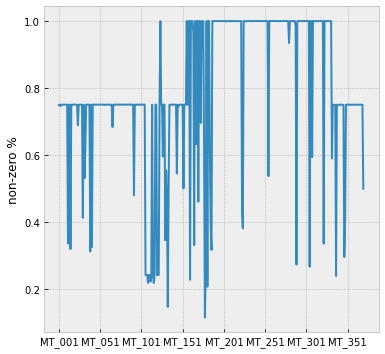

In [10]:
(eldata!=0).mean().plot()
plt.ylabel("non-zero %")

Indeed, we can see that some clients have low percentage of non-zero values

To examine how much variance there is among the magnidute of values between clients lets plot the medians of all the clients (sorted):

C:\Users\Yair\miniconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0, 0.5, 'magnitude')

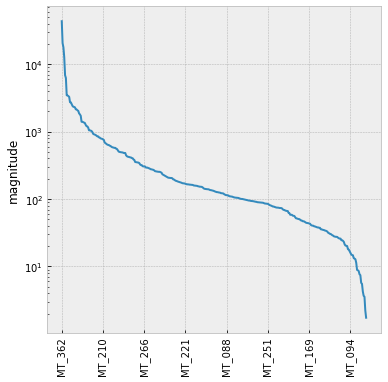

In [11]:
eldata[eldata!=0].median().sort_values(ascending=False).plot(rot=90)
plt.yscale("log")

plt.ylabel("magnitude")

We can see that majority of the clients lie in the values region of $10^{2}$ - $10^{3}$. However, there is a difference of almost 5 orders of magnitude (!) between the minimal median to the maximal one, hence we should normalize the input before feeding the net.

# Dataset and DataModule

In [12]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

## Dataset

In [113]:
class ElectricityLoadDataset(Dataset):
    """Sample data from electricity load dataset (per household, resampled to one hour)."""

    def __init__(self, df, samples, hist_len=168, fct_len=24):
        self.hist_num = hist_len
        self.fct_num = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)
        self.samples = samples

        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
        self.raw_data = df.copy()

        assert samples <= self.raw_data[:self.max_ts].shape[0]

        self.sample()

    def sample(self):
        """Sample individual series as needed."""

        # Calculate actual start for each household
        self.clean_start_ts = (self.raw_data!=0).idxmax()

        households = []

        for hh in self.raw_data.columns:
            hh_start = self.clean_start_ts[hh]
            hh_nsamples = min(self.samples, self.raw_data.loc[hh_start:self.max_ts].shape[0])

            hh_samples = (self.raw_data
                          .loc[hh_start:self.max_ts]
                          .index
                          .to_series()
                          .sample(hh_nsamples, replace=False)
                          .index)
            households.extend([(hh, start_ts) for start_ts in hh_samples])

        self.samples = pd.DataFrame(households, columns=("household", "start_ts"))

        # Adding calendar features
        # In fact we should use self.raw_data shifted by 1 since the calendar features are deterministic hence unlike
        # the endogenos part when we use z(t) to predict z(t+1), we can use x(t) to predict z(t) but anywy since the feature is
        # in fact fourier feature it is not critical
        self.raw_data["yearly_cycle"] = np.sin(2 * np.pi * self.raw_data.index.dayofyear / 366)
        self.raw_data["weekly_cycle"] = np.sin(2 * np.pi * self.raw_data.index.dayofweek / 7)
        self.raw_data["daily_cycle"] = np.sin(2 * np.pi * self.raw_data.index.hour / 24)
        self.calendar_features = ["yearly_cycle", "weekly_cycle", "daily_cycle"]

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        household, start_ts = self.samples.iloc[idx]

        hs, he = start_ts, start_ts + self.hist_len - self.offset
        fs, fe = he + self.offset, he + self.fct_len

#         hist_data = self.raw_data.loc[hs:, [household] + self.calendar_features].iloc[:self.hist_num]
#         fct_data = self.raw_data.loc[fs:, [household] + self.calendar_features].iloc[:self.fct_num]
        hist_data = self.raw_data.loc[hs:he, [household] + self.calendar_features]
        fct_data = self.raw_data.loc[fs:fe, [household] + self.calendar_features]
        
        # scaling: 
        mean = hist_data.loc[:,household].mean()
        std = hist_data.loc[:,household].std()
        if std == 0:
            std = 1
        hist_data.loc[:,household] = (hist_data.loc[:,household] - mean) / std
        fct_data.loc[:,household] = (fct_data.loc[:,household] - mean) / std

        return (torch.Tensor(hist_data.values),
                torch.Tensor(fct_data.values), (mean,std))

## Test ElectricityLoadDataset

In [87]:
ds = ElectricityLoadDataset(eldata, 100)

In [88]:
hist, fct, (mean, std) = ds[4]

In [89]:
mean, std

(4.147026831036984, 5.352126986620639)

### Check correct length

In [77]:
hist.shape

torch.Size([168, 4])

In [78]:
fct.shape

torch.Size([24, 4])

### Check number of samples per household

In [79]:
ds.samples

,household,start_ts
0,MT_001,2014-05-30 11:00:00
1,MT_001,2013-04-25 22:00:00
2,MT_001,2013-11-01 15:00:00
3,MT_001,2013-10-13 08:00:00
4,MT_001,2014-07-03 12:00:00
...,...,...
36995,MT_370,2014-06-30 11:00:00
36996,MT_370,2013-01-12 08:00:00
36997,MT_370,2013-05-04 06:00:00
36998,MT_370,2013-09-20 16:00:00


In [80]:
ds.samples.groupby("household").size().unique()

array([100], dtype=int64)

we got 100 samples per client, as expected

### Check Data correctness

we check correctness by comparing the data we get from the dataset loader to the corresponding raw data. For that we first get the household and the start timestamp from the samples attribute for the same index we sampled earlier to get hist, fct and (mean, std) and get the corresponding data directly from the dataframe:

In [91]:
household, start_ts = ds.samples.iloc[4]

In [92]:
eldata.loc[start_ts:,household].head()

timestamp
2013-08-25 20:00:00    14.911168
2013-08-25 21:00:00    15.545685
2013-08-25 22:00:00    15.228426
2013-08-25 23:00:00    17.766497
2013-08-26 00:00:00    15.862944
Freq: H, Name: MT_001, dtype: float64

In [93]:
eldata.loc[start_ts+pd.Timedelta(days=7):,household].head()

timestamp
2013-09-01 20:00:00    0.634518
2013-09-01 21:00:00    0.951777
2013-09-01 22:00:00    1.269036
2013-09-01 23:00:00    1.269036
2013-09-02 00:00:00    0.951777
Freq: H, Name: MT_001, dtype: float64

Now, comparing the above to the un-normalized data we got from the dataset loader:

In [90]:
hist[:,0]*std +mean, fct[:,0]*std + mean

(tensor([14.9112, 15.5457, 15.2284, 17.7665, 15.8629, 15.2284, 15.5457, 15.8629,
         15.2284, 15.5457, 15.5457, 14.5939, 19.6701, 13.6421, 13.6421, 19.9873,
         13.6421, 13.6421, 13.6421,  6.9797,  0.6345,  0.6345,  0.6345,  0.9518,
          1.5863,  2.2208,  2.2208,  4.1244,  2.5381,  2.2208,  2.2208,  2.5381,
          2.2208,  2.2208,  7.2970, 15.2284, 13.6421,  8.5660,  1.2690,  1.2690,
          1.2690,  0.9518,  1.2690,  1.2690,  0.6345,  0.6345,  0.9518,  1.2690,
          1.2690,  2.2208,  2.5381,  4.1244,  2.5381,  2.2208,  2.2208,  2.2208,
          2.5381,  1.9036,  2.8553,  1.5863,  1.9036, 13.6421, 13.3249,  7.9315,
          0.6345,  0.6345,  0.3173,  0.6345,  0.9518, 20.6218,  5.7107,  2.2208,
          2.8553,  3.1726,  3.1726,  2.8553,  2.8553,  2.8553,  2.5381,  2.5381,
          2.5381,  2.8553,  2.8553,  2.2208,  3.1726,  7.9315,  0.9518,  0.6345,
          0.6345,  0.6345,  0.6345,  0.3173,  0.9518,  1.5863,  0.6345,  1.2690,
          2.8553,  3.1726,  

we see that the data is identical, as expected

## DataModule

In [24]:
class ElectricityLoadDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df,
                 train=0.7, 
                 val=0.2,
                 test=0.1,
                 samples=100,
                 batch_size=64,
                 workers=3):

        super().__init__()

        assert train + val + test <= 1

        self.raw_data = df
        self.train_size = int(train * df.shape[1])
        self.val_size = int(val * df.shape[1])
        self.test_size = df.shape[1] - self.train_size - self.val_size

        self.samples = samples
        self.batch_size = batch_size
        self.workers = workers
        self.split()

    def split(self):
        hh_rand = (self.raw_data
                   .columns
                   .to_series()
                   .sample(self.raw_data.shape[1],
                           replace=False))

        self.train_hh = hh_rand.iloc[:self.train_size].index
        self.val_hh = hh_rand.iloc[self.train_size:(self.val_size + self.train_size)].index
        self.test_hh = hh_rand.iloc[-self.test_size:].index

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[self.train_hh]
            val_df = self.raw_data[self.val_hh]

            self.train_ds = ElectricityLoadDataset(train_df,
                                                   samples=self.samples)
            self.val_ds = ElectricityLoadDataset(val_df,
                                                 samples=self.samples)

        if stage == "test" or stage is None:
            test_df = self.raw_data[self.test_hh]
            self.test_ds = ElectricityLoadDataset(test_df,
                                              samples=self.samples)

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers, shuffle=True)

In [98]:
# dm = ElectricityLoadDataModule(eldata)
dm = ElectricityLoadDataModule(eldata, workers=0)
dm.setup()

check the train set is not overlapped with the val or test sets and that they all summed up to 370:

In [99]:
assert dm.train_hh.intersection(dm.val_hh).empty
assert dm.train_hh.intersection(dm.test_hh).empty
assert dm.train_hh.size + dm.val_hh.size + dm.test_hh.size == 370

make some tests on sampled train batch:

In [101]:
x, y, (mean, std) = next(iter(dm.train_dataloader()))

In [102]:
x.shape, y.shape

(torch.Size([64, 168, 4]), torch.Size([64, 24, 4]))

In [103]:
mean

tensor([697.6143, 788.0562, 691.7211, 679.5984, 662.3070, 921.9327, 865.7135,
        710.4213, 775.7678, 712.7246, 797.0923, 854.1829, 653.7629, 762.7290,
        772.7722, 769.2926, 838.4970, 621.5809, 825.2930, 940.2728, 818.0449,
        763.8770, 702.1124, 623.9051, 969.8743, 855.2892, 842.6902, 801.1701,
        805.3342, 684.4439, 828.9526, 681.6063, 785.7264, 776.8368, 811.6276,
        856.4683, 661.6376, 633.7344, 915.1637, 838.5280, 895.7453, 645.6672,
        865.4248, 814.8188, 920.1306, 712.4295, 804.5094, 660.0824, 742.5089,
        850.3592, 628.8418, 866.5130, 830.6252, 747.2099, 880.5815, 773.0304,
        720.3945, 770.8671, 718.3910, 889.0483, 793.0680, 773.8744, 724.0575,
        824.5884], dtype=torch.float64)

In [104]:
std

tensor([165.9402, 335.7492, 145.4292, 156.4059, 183.0656, 353.4565, 293.2394,
        162.8858, 231.1091, 164.3889, 276.6839, 320.6510, 184.9482, 243.6984,
        235.1621, 185.4112, 353.8288, 131.7844, 289.4974, 351.6039, 283.3312,
        332.7993, 169.4588, 132.4132, 371.7457, 248.2048, 339.6733, 209.7125,
        230.9562, 144.5658, 248.7498, 165.6074, 187.0560, 340.0448, 341.0567,
        318.5059, 169.3478, 152.0916, 346.6151, 224.2468, 346.6891, 137.9709,
        308.7046, 330.1637, 352.0061, 337.6720, 337.6001, 162.0091, 224.9441,
        339.7314, 171.7197, 306.2212, 253.8573, 185.9675, 373.9425, 209.5374,
        182.0341, 191.0223, 266.3840, 289.3970, 342.9600, 203.3580, 180.4152,
        290.4129], dtype=torch.float64)

check that we get the expected number of samples for the test set:

In [31]:
dm.test_ds.samples

,household,start_ts
0,MT_052,2013-04-03 06:00:00
1,MT_052,2012-08-19 15:00:00
2,MT_052,2013-04-29 01:00:00
3,MT_052,2013-10-08 03:00:00
4,MT_052,2012-05-27 01:00:00
...,...,...
3695,MT_009,2013-05-13 15:00:00
3696,MT_009,2013-11-13 11:00:00
3697,MT_009,2014-02-06 15:00:00
3698,MT_009,2014-01-23 05:00:00


Indeed, since the test is 10% of the data = 37 households, and we sample each household 100 times we get the expected total number of samples - 3700

# Model

In [290]:
class ElectricityModel(pl.LightningModule):
    """Encoder network for MQ-RNN forecast model."""
    def __init__(self, hist_len=168, fct_len=24, input_size=4, num_layers=1, hidden_units=8, ct_size=8, ca_size=8,
                 quantiles=[0.1,0.5,0.9], min_hist_len = 120, lr=1e-3):
        super().__init__()
        self.hist_len = hist_len
        self.fct_len = fct_len
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_units = hidden_units
        self.ct_size = ct_size
        self.ca_size = ca_size
        self.quantiles = quantiles
        self.n_quantiles = len(quantiles)
        self.min_hist_len = min_hist_len
        self.lr = lr
        self.global_in_features = hidden_units + fct_len * (input_size - 1)
        self.global_out_features = ca_size + fct_len * ct_size
        self.local_in_features = ca_size + ct_size + input_size - 1

        self.encoder = nn.LSTM(input_size=self.input_size,
                               hidden_size=self.hidden_units,
                               num_layers=self.num_layers,
                               batch_first=True)
        self.global_mlp = nn.Linear(in_features= self.global_in_features, out_features=self.global_out_features)
        self.local_mlp = nn.Linear(in_features=self.local_in_features, out_features=self.n_quantiles)

    def forward(self, x, x_f, hidden=None):
        # x is of size (batch_size, x_seq_len, input_size), where x_seq_len can be any arbitrary sequence length
        # and x_f is of size (batch_size, fct_len, input_size - 1) since it contains only the exogenous covariates
        
        # get the hidden state from the encoder
        _, (hn, cn) = self.encoder(x, hidden)
        
        # concatenate the hidden state with the future covariates. h_n is of size (1, batch_size, hidden_units) so I will
        # squeeze it and reshape x_f to get the desired number of in_features.
        hn_s = hn.squeeze() # to get (batch_size,hidden_units) size
        x_f_vec = x_f.reshape(-1, x_f.shape[1] * x_f.shape[2]) # to get (batch_size, fct_len * (input_size - 1)) size
        global_input = torch.cat([x_f_vec,hn_s], dim=1)
        contexts = self.global_mlp(global_input) # (batch_size, ca_size + fct_len * ct_size)
        
        # create ct :tensor with batch_size in 1st dim., fct_len in the 2nd and ct_size in the 3rd.
        ct = contexts[:,self.ca_size:].reshape(-1, self.fct_len, self.ct_size)
        # ca is constant to all horizon so we need to replicate it in the 2nd dim (after reshpe from 2 to 3 dims.)
        ca = contexts[:,:self.ca_size].view(-1, 1, self.ca_size).expand(-1,self.fct_len,-1)
        local_input = torch.cat([ca,ct,x_f],dim=2) # to get (batch_size, fct_len, ca_size + ct_size + input_size - 1) size
        y_hat = self.local_mlp(local_input) # (barch_size, fct_len, n_quantiles)
        
        return y_hat, hn, cn
    
    def training_step(self, batch, batch_idx):
        
        x, y, _ = batch
        x_cat = torch.cat([x, y], dim=1)
        
        # first forward on min_hist_len to get the hidden states and compute the corresponding loss
        y_hat, hn, cn = self(x_cat[:, :self.min_hist_len, :], x_cat[:, self.min_hist_len:self.min_hist_len+self.fct_len, 1:])
        loss = self.loss(y_hat, x_cat[:, self.min_hist_len:self.min_hist_len+self.fct_len, [0]])
        
        # forking-sequences implementation: we move on the hist. series one by one and forecast for the next <fct_len>, 
        # then add the current loss to the aggregated one
        for i in range(self.min_hist_len,self.hist_len):
            y_hat, hn, cn = self(x_cat[:, i:i+1, :], x_cat[:, i+1:i+1+self.fct_len, 1:], (hn, cn))
            loss += self.loss(y_hat, x_cat[:, i+1:i+1+self.fct_len, [0]])
        
        return loss / (self.hist_len - self.min_hist_len + 1)
            
    def validation_step(self, batch, batch_idx):
        # we need to validate only on full length series (and not perform forking-sequences as in the training)
        x, y, _ = batch
        
        y_hat, hn, cn = self(x, y[:, :, 1:])
        loss = self.loss(y_hat, y[:, :, [0]])

        self.log('val_QL', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def loss(self, y_hat, y):
        # y, y_hat and self.quantiles need to be broadcastable: https://pytorch.org/docs/stable/notes/broadcasting.html
        # usually y: (batch_size, fct_len, 1), y_hat: (batch_size,fct_len,self.n_quantiles), quantiles: (self.n_quantiles)
        zeros = torch.zeros_like(y_hat)
        quantiles = torch.tensor(self.quantiles,device=y.device)
        error = y - y_hat
        return torch.mean(quantiles * torch.maximum(error, zeros) + (1 - quantiles) * torch.maximum(-error, zeros))       


## Test ElectricityModel

In [291]:
dm = ElectricityLoadDataModule(eldata, batch_size=128, workers=0)
model = ElectricityModel(lr=1e-3, hidden_units=64, ca_size = 64, ct_size = 16, num_layers=1)

In [292]:
dm.setup()
batch = next(iter(dm.train_dataloader()))
# batch = next(iter(dm.test_dataloader()))
X, y, (mean, std) = batch

In [293]:
y_hat, _, _ = model.forward(X, y[:,:,1:])

In [294]:
y_hat.shape

torch.Size([128, 24, 3])

as expected the sequence length of the output is 24 and its size is 3 as the number of quantiles (those 2 parameters ofcourse can be changed in the model init.

test that the training step runs without errors:

In [295]:
model.training_step(batch, 0)

tensor(0.4325, grad_fn=<DivBackward0>)

## Training

In [383]:
# scaled_data = eldata / eldata[eldata!=0].mean() - 1

In [185]:
# dm = ElectricityLoadDataModule(scaled_data, batch_size=128, workers=0)
dm = ElectricityLoadDataModule(eldata, batch_size=128, workers=0)
model = ElectricityModel(lr=1e-3, hidden_units=64, ca_size = 64, ct_size = 16, quantiles = [0.01,0.1,0.5,0.9,0.99],
                         num_layers=1)
trainer = pl.Trainer(max_epochs=20, progress_bar_refresh_rate=1, gpus=1)
# trainer = pl.Trainer(max_epochs=5, progress_bar_refresh_rate=1, accelerator='ddp_cpu')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [186]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | encoder    | LSTM   | 17.9 K
1 | global_mlp | Linear | 61.4 K
2 | local_mlp  | Linear | 420   
--------------------------------------
79.7 K    Trainable params
0         Non-trainable params
79.7 K    Total params
0.319     Total estimated model params size (MB)


C:\Users\Yair\miniconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
C:\Users\Yair\miniconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


C:\Users\Yair\miniconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Testing

In [203]:
dm.setup(stage="test")

C:\Users\Yair\miniconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "


In [285]:
batch = next(iter(dm.test_dataloader()))

In [286]:
X, y, (mean, std) = batch

In [206]:
X.shape

torch.Size([128, 168, 4])

In [208]:
result = model(X, y[:,:,1:])

In [209]:
result[0].shape

torch.Size([128, 24, 5])

In [210]:
std.shape

torch.Size([128])

In [288]:
res = result[0]*std.view(-1,1,1) + mean.view(-1,1,1)
x = X[:,:,0]*std.view(-1,1) + mean.view(-1,1)
y = y[:,:,0]*std.view(-1,1) + mean.view(-1,1)

res = res.cpu().detach().numpy()
x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()

quantiles_num = len(model.quantiles)
half = (quantiles_num - 1) // 2


In [251]:
res.shape

(128, 24, 5)

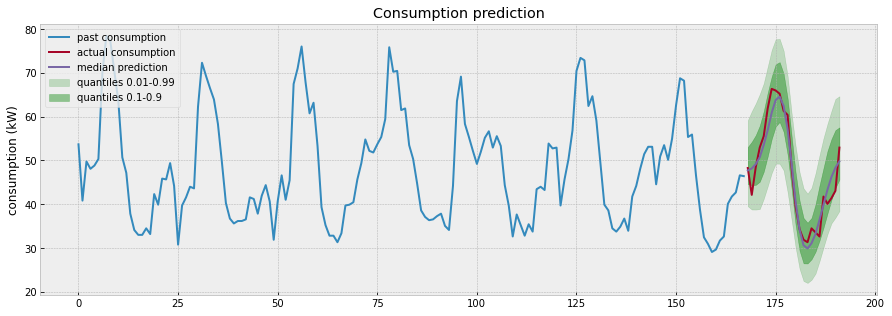

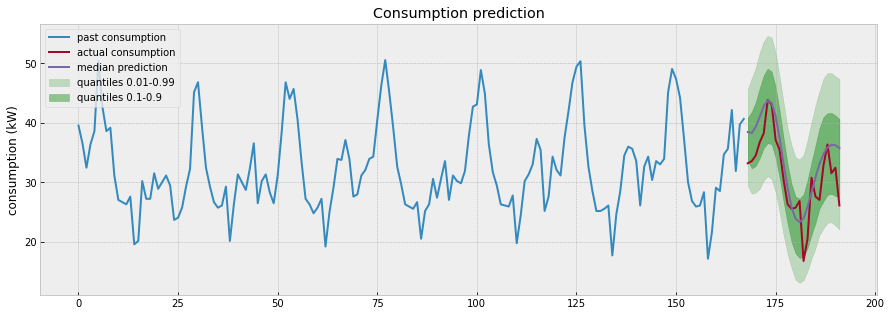

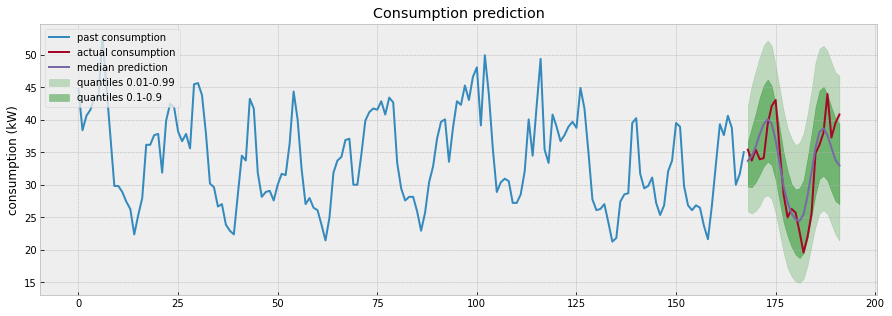

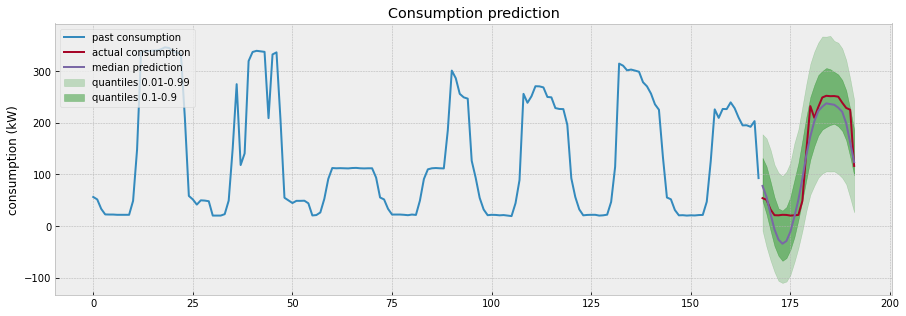

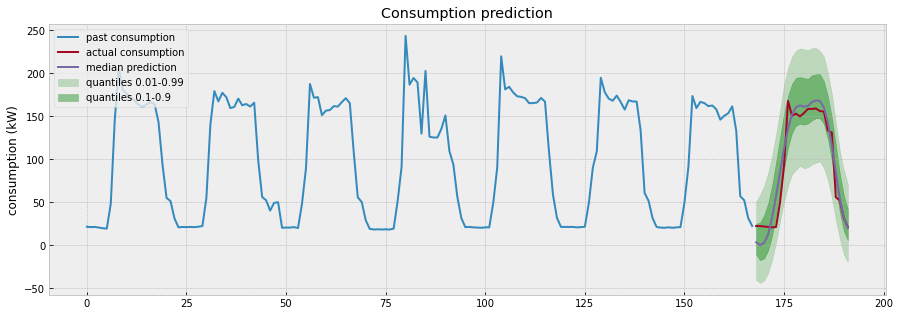

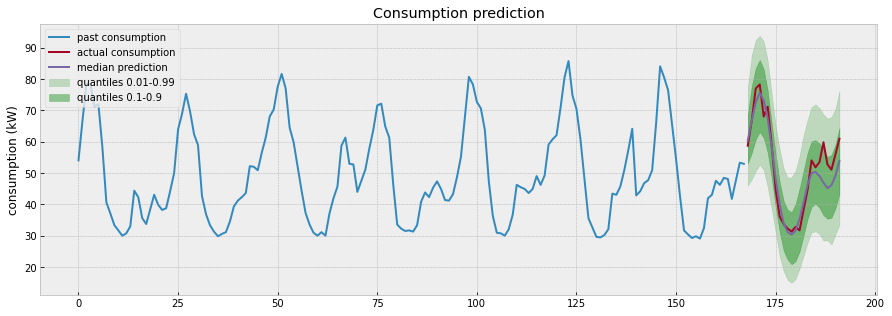

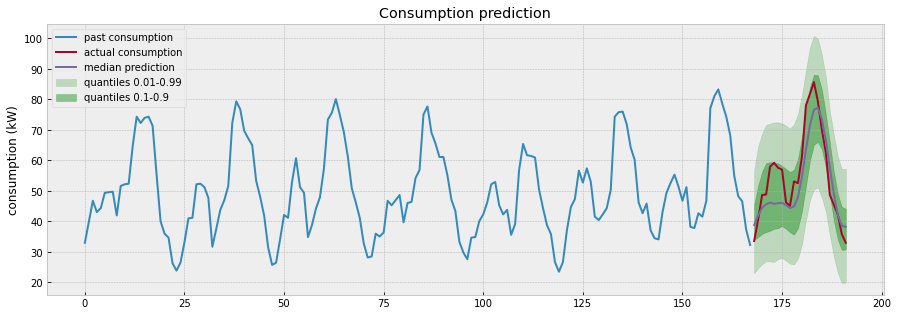

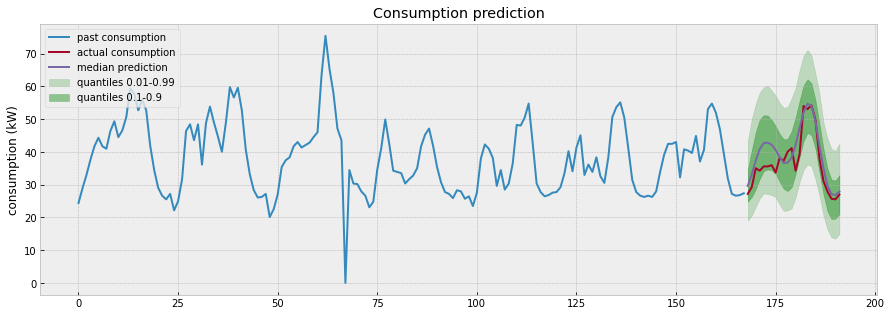

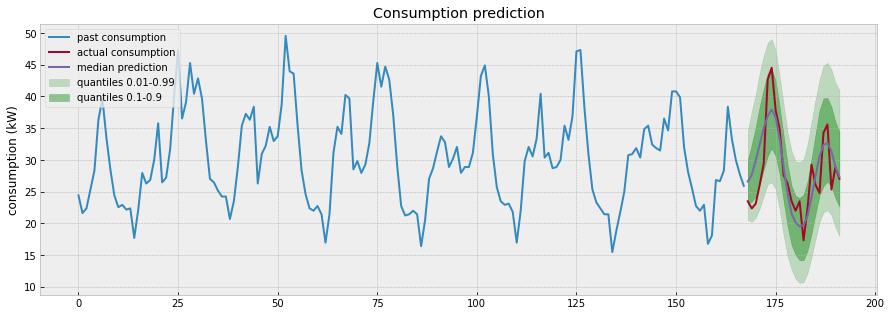

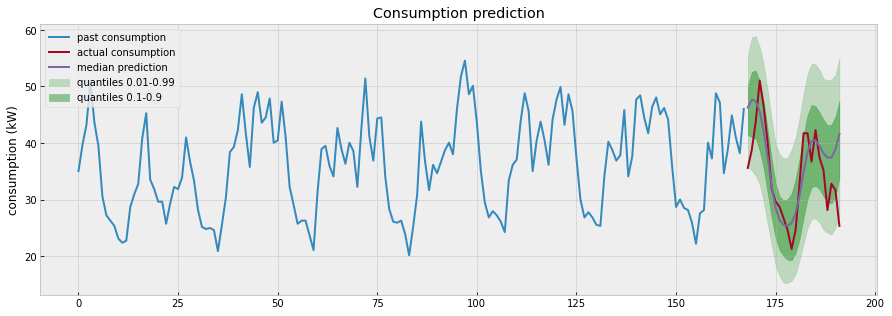

In [289]:
samples = np.random.randint(res.shape[0],size=10)

for n in samples:
    fig = plt.figure(figsize=(15,5))
    plt.title("Consumption prediction")
    plt.plot(x[n,:], label="past consumption")
    plt.plot(np.arange(168, 192, 1), y[n, :], label="actual consumption")
    plt.plot(np.arange(168, 192, 1), res[n, :, half], label="median prediction")
    # res = res[:, 1:]
    for i in range(half):
        alph = 0.0 + (i + 1)/ quantiles_num
        plt.fill_between(np.arange(168, 192, 1), res[n, :, i], res[n, :, -(i + 1)],
                         color="g", alpha=alph, label=f"quantiles {model.quantiles[i]}-{model.quantiles[-(i + 1)]}")

    plt.legend(loc="upper left")
    # plt.grid()
    # plt.tight_layout()
    plt.ylabel("consumption (kW)")
    plt.show()

In [270]:
loaded_model = ElectricityModel.load_from_checkpoint("lightning_logs/version_40/checkpoints/epoch=6-step=1420.ckpt",
                                      hidden_units=64, ca_size = 64, ct_size = 16, quantiles = [0.01,0.1,0.5,0.9,0.99])

In [287]:
result = loaded_model(X, y[:,:,1:])